In [1]:
# xgboost with proper data preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
from google.colab import files


uploaded = files.upload()

Saving mimic_v6_labelled.csv to mimic_v6_labelled.csv


In [3]:
#import libraries and data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [4]:

df = pd.read_csv("/content/mimic_v6_labelled.csv")

print(df.shape)

(26176, 28)


In [5]:
# Identify and replace erroneous temp values
# Sort the DataFrame by subject_id and any other relevant column (e.g., timestamp)
df.sort_values(by=['subject_id', 'admittime'], inplace=True)

# Create a function to replace the values of 6 with the last value above 30
def replace_values(group):
    last_above_30 = None
    new_temp = []

    for temp in group['temp']:
        if temp > 30:
            last_above_30 = temp
        elif last_above_30 is None:
            last_above_30 = 36.66667  # Default value if no values above 30
        new_temp.append(last_above_30 if temp in (4, 5, 6) else temp)

    group['temp'] = new_temp
    return group


# Apply the function to each group of unique participants
df = df.groupby('subject_id').apply(replace_values)

# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)

<ipython-input-5-63ef52bf1172>:22: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('subject_id').apply(replace_values)


In [6]:
# clean df, remove unrequired features and setup categorical and numerical df
df['Medication_count'] = df['unique_cv_items_count'] + df['unique_mv_items_count']


bin_edges = [0, 1, 2, 3, 4, float('inf')]
bin_labels = ['1', '2', '3', '4', '>4']

# Apply binning to the 'num_unique_icd9_codes' column
df['num_unique_icd9_codes_bin'] = pd.cut(df['num_unique_icd9_codes'], bins=bin_edges, labels=bin_labels)

# Apply binning to the 'Medication_count' column
df['Medication_count_bin'] = pd.cut(df['Medication_count'], bins=bin_edges, labels=bin_labels)

df = df.drop(columns=['Unnamed: 0.1','Unnamed: 0','subject_id','admittime',
                      'deathtime','marital_status',
                      'hadm_id', 'icd9_code_2','icd9_code_3',
                      'dischtime','admission_type',
                      'unique_cv_items_count','unique_mv_items_count',
                      'num_unique_icd9_codes','Medication_count','diagnosis'])

df= df.dropna()

In [7]:
# replace Age > 300
def replace_above_300(value):
    if value > 300:
        return value - 210
    return value

# Apply the function to the 'age' column
df['age'] = df['age'].apply(replace_above_300)

In [8]:
df.describe()

,age,los,icd9_code_1,hr,nbp,spo2,rr,temp,Label
count,20883.000000,20883.000000,20883.000000,20883.000000,20883.000000,20883.000000,20883.000000,20883.000000,20883.000000
mean,63.304587,10.967243,4879.559690,88.512580,87.774858,97.259015,18.516545,33.622603,0.121391
std,17.304137,10.737337,3103.902339,20.586571,832.051419,4.633746,6.203092,10.019697,0.326588
min,18.022083,-0.116667,11.000000,0.000000,0.000000,0.000000,0.000000,0.777778,0.000000
25%,51.942804,4.739583,3601.000000,75.000000,69.000000,96.000000,14.000000,36.444401,0.000000
50%,64.843536,7.865972,3951.000000,87.000000,80.000000,98.000000,18.000000,36.666670,0.000000
75%,77.225612,13.505556,8102.000000,100.000000,92.333298,100.000000,22.000000,36.666670,0.000000
max,100.280859,202.762500,9978.000000,941.000000,120130.030000,100.000000,160.000000,40.833302,1.000000


In [9]:
df.keys()

Index(['age', 'gender', 'los', 'discharge_location', 'insurance', 'ethnicity',
       'icd9_code_1', 'hr', 'nbp', 'spo2', 'rr', 'temp', 'Label',
       'num_unique_icd9_codes_bin', 'Medication_count_bin'],
      dtype='object')

In [10]:
categ_columns = ['gender','discharge_location','insurance','ethnicity',
                      'icd9_code_1','num_unique_icd9_codes_bin','Medication_count_bin']

from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for column in categ_columns:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])
  label_encoders[column] = label_encoder


In [11]:
# split into X and y
y_df = df['Label']
y_df.columns = ['Label']

In [12]:
# Split X numerical and Categorical
x_df = df.copy()

#x_df_cat = x_df[['gender','discharge_location','insurance','ethnicity',
               # 'icd9_code_1','num_unique_icd9_codes_bin','Medication_count_bin']].copy()

x_df_cat = pd.get_dummies(df[['discharge_location','insurance','ethnicity','icd9_code_1','gender', 'Medication_count_bin', 'num_unique_icd9_codes_bin']])

x_df_num = x_df.drop(['gender','discharge_location','insurance','ethnicity',
                      'icd9_code_1','Label','num_unique_icd9_codes_bin','Medication_count_bin'], axis = 1).astype('float64')
x_df_num

,age,los,hr,nbp,spo2,rr,temp
0,76.526788,10.784722,95.0,36.666698,98.0,16.0,36.055599
1,47.845044,7.759028,111.0,80.666702,98.0,18.0,37.444401
2,50.148292,25.529167,90.0,64.000000,96.0,19.0,37.222198
3,39.866116,6.855556,80.0,71.333298,98.0,19.0,37.277802
5,50.841554,2.206250,95.0,113.667000,100.0,27.0,37.666698
...,...,...,...,...,...,...,...
26171,65.262831,6.814583,71.0,66.000000,95.0,18.0,36.666670
26172,65.377831,6.128472,94.0,71.000000,99.0,21.0,36.666670
26173,78.576622,3.079861,69.0,82.000000,98.0,21.0,36.666670
26174,53.808478,16.595833,118.0,102.000000,84.0,33.0,36.666670


In [13]:
# numerical is under x_df_num
X_numerical = x_df_num

In [14]:
print(len(x_df), len(y_df), len(x_df_num))

20883 20883 20883


In [15]:
list_numerical = X_numerical.columns
list_numerical

Index(['age', 'los', 'hr', 'nbp', 'spo2', 'rr', 'temp'], dtype='object')

In [16]:
for key in x_df_cat.keys():
    print('CATEGORICAL KEYS', key)

for key in x_df_num.keys():
    print('\n','NUMERIC KEYS',key)

CATEGORICAL KEYS discharge_location
CATEGORICAL KEYS insurance
CATEGORICAL KEYS ethnicity
CATEGORICAL KEYS icd9_code_1
CATEGORICAL KEYS gender
CATEGORICAL KEYS Medication_count_bin
CATEGORICAL KEYS num_unique_icd9_codes_bin

 NUMERIC KEYS age

 NUMERIC KEYS los

 NUMERIC KEYS hr

 NUMERIC KEYS nbp

 NUMERIC KEYS spo2

 NUMERIC KEYS rr

 NUMERIC KEYS temp


In [17]:
# Scale numerical features
scaled_x_df_num = pd.DataFrame(StandardScaler().fit_transform(x_df_num), columns = x_df_num.keys())

In [18]:
scaled_x_df_num.describe()

,age,los,hr,nbp,spo2,rr,temp
count,2.088300e+04,2.088300e+04,2.088300e+04,2.088300e+04,2.088300e+04,2.088300e+04,2.088300e+04
mean,-5.335110e-16,-1.224898e-16,-1.742077e-16,-1.360997e-18,2.653945e-17,-2.041496e-16,6.532788e-16
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00
min,-2.616923e+00,-1.032302e+00,-4.299633e+00,-1.054946e-01,-2.098979e+01,-2.985122e+00,-3.278104e+00
25%,-6.566092e-01,-5.800142e-01,-6.563941e-01,-2.256508e-02,-2.717121e-01,-7.281292e-01,2.816318e-01
50%,8.893741e-02,-2.888374e-01,-7.347585e-02,-9.344428e-03,1.599145e-01,-8.327410e-02,3.038155e-01
75%,8.045104e-01,2.364062e-01,5.580189e-01,5.478686e-03,5.915411e-01,5.615810e-01,3.038155e-01
max,2.136897e+00,1.786289e+01,4.141087e+01,1.442761e+02,5.915411e-01,2.280908e+01,7.196695e-01


In [19]:
# Find outliers based on 1.5*(Q3-Q1) outlier step
outliers  = []
# For each feature find the data points with extreme high or low values
for feature in scaled_x_df_num.keys():
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(scaled_x_df_num[feature],25)
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(scaled_x_df_num[feature],75)
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    outliers_per_feature = scaled_x_df_num[~((scaled_x_df_num[feature] >= Q1 - step) & (scaled_x_df_num[feature] <= Q3 + step))]
    outliers = outliers + list(outliers_per_feature.index)
outliers.sort()
outliers = list(set(outliers))

# Remove outliers
clean_scaled_x_df_num = scaled_x_df_num.drop(scaled_x_df_num.index[outliers]).reset_index(drop = True)
print('{} outliers removed'.format(len(outliers)))

8816 outliers removed


In [20]:
# Convert categorical features to "One Hot Encoding" vectors and drop outliers
clean_x_df_cat = x_df_cat.drop(x_df_cat.index[outliers]).reset_index(drop = True)
# clean_x_df_cat_ohe = pd.get_dummies(clean_x_df_cat, drop_first=True)
# dummies = pd.get_dummies(clean_x_df_cat)

In [21]:
# Recombine scaled numerical and encoded categorical features by concatination
x_df = pd.concat([clean_scaled_x_df_num, clean_x_df_cat], axis = 1)
# x_df = pd.concat([clean_scaled_x_df_num, dummies], axis = 1)

In [22]:
# Drop outliers from label Dataframe as well
y_df = y_df.drop(y_df.index[outliers]).reset_index(drop = True)

In [23]:
print(len(y_df), len(x_df))

12067 12067


In [24]:
y_df.columns = ['Label']

In [25]:
print(y_df.value_counts())
print('\nPositive label proportion: ')
print(y_df.value_counts()/y_df.shape[0])

0    10658
1     1409
Name: Label, dtype: int64

Positive label proportion: 
0    0.883235
1    0.116765
Name: Label, dtype: float64


In [62]:
# write final files to local dir
x_df.to_csv('/content/x_df.csv')
y_df.to_csv('/content/y_df.csv')

In [ ]:
# XGBOOST TIME

In [63]:
#import all relevant libraries
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc
from scipy import interp

%matplotlib inline

In [64]:
# Read preprocessed dataframes produced in notebook 2_preprocessing.ipynb
x_df = pd.read_csv('/content/x_df.csv')
y_df = pd.read_csv('/content/y_df.csv')

In [65]:
print(x_df.keys())
x_df = x_df.drop(columns = ['Unnamed: 0'])
print(x_df.keys())

Index(['Unnamed: 0', 'age', 'los', 'hr', 'nbp', 'spo2', 'rr', 'temp',
       'discharge_location', 'insurance', 'ethnicity', 'icd9_code_1', 'gender',
       'Medication_count_bin', 'num_unique_icd9_codes_bin'],
      dtype='object')
Index(['age', 'los', 'hr', 'nbp', 'spo2', 'rr', 'temp', 'discharge_location',
       'insurance', 'ethnicity', 'icd9_code_1', 'gender',
       'Medication_count_bin', 'num_unique_icd9_codes_bin'],
      dtype='object')


In [66]:
# Define the class weight scale (a hyperparameter) as the ration of negative labels to positive labels.
# This instructs the classifier to address the class imbalance.
class_weight_scale = 1.*y_df.Label.value_counts()[0]/y_df.Label.value_counts()[1]
class_weight_scale

7.564229950319375

In [67]:
param={
    'objective':'binary:logistic',
    'nthread':4,
    'scale_pos_weight':class_weight_scale,
    'seed' : 1
}
xgb1 = XGBClassifier()
xgb1.set_params(**param)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

class weight scale : 7.565217391304348


<ipython-input-68-756200e3f080>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


class weight scale : 7.565217391304348


<ipython-input-68-756200e3f080>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


class weight scale : 7.558510638297872


<ipython-input-68-756200e3f080>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


class weight scale : 7.566104702750666


<ipython-input-68-756200e3f080>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


class weight scale : 7.566104702750666


<ipython-input-68-756200e3f080>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


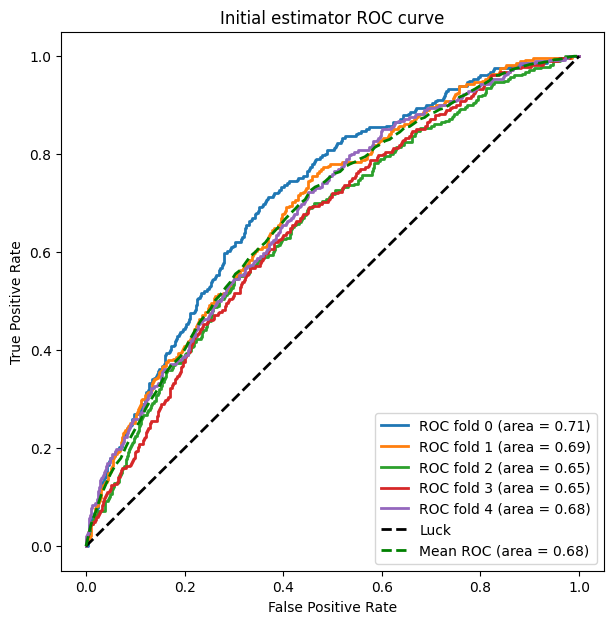

In [68]:
# Train initial classifier and analyze performace using K-fold cross-validation
K = 5
eval_size = int(np.round(1./K))
skf = StratifiedKFold(n_splits=K)

fig = plt.figure(figsize=(7,7))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
lw = 2
i = 0
roc_aucs_xgb1 = []
for train_indices, test_indices in skf.split(x_df, y_df['Label']):
    X_train, y_train = x_df.iloc[train_indices], y_df['Label'].iloc[train_indices]
    X_valid, y_valid = x_df.iloc[test_indices], y_df['Label'].iloc[test_indices]
    class_weight_scale = 1.*y_train.value_counts()[0]/y_train.value_counts()[1]
    print('class weight scale : {}'.format(class_weight_scale))
    xgb1.set_params(**{'scale_pos_weight' : class_weight_scale})
    xgb1.fit(X_train,y_train)
    xgb1_pred_prob = xgb1.predict_proba(X_valid)
    fpr, tpr, thresholds = roc_curve(y_valid, xgb1_pred_prob[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    roc_aucs_xgb1.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= K
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Initial estimator ROC curve')
plt.legend(loc="lower right")

fig.savefig('/content/initial_ROC.png')

In [69]:
optimize = True

In [70]:
X_train = x_df
y_train = y_df['Label']

if optimize:

    param_test0 = {
     'n_estimators':range(50,250,10)
    }
    print('performing hyperparamter optimization step 0')
    gsearch0 = GridSearchCV(estimator = xgb1, param_grid = param_test0,
                            scoring='roc_auc',n_jobs=4, cv=5)
    gsearch0.fit(X_train,y_train)
    print(gsearch0.best_params_, gsearch0.best_score_)

    param_test1 = {
     'max_depth':range(1,10),
     'min_child_weight':range(1,10)
    }
    print('performing hyperparamter optimization step 1')
    gsearch1 = GridSearchCV(estimator = gsearch0.best_estimator_,
     param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
    gsearch1.fit(X_train,y_train)
    print(gsearch1.best_params_, gsearch1.best_score_)

    max_d = gsearch1.best_params_['max_depth']
    min_c = gsearch1.best_params_['min_child_weight']

    param_test2 = {
     'gamma':[i/10. for i in range(0,5)]
    }
    print('performing hyperparamter optimization step 2')
    gsearch2 = GridSearchCV(estimator = gsearch1.best_estimator_,
     param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
    gsearch2.fit(X_train,y_train)
    print(gsearch2.best_params_, gsearch2.best_score_)

    param_test3 = {
        'subsample':[i/10.0 for i in range(1,10)],
        'colsample_bytree':[i/10.0 for i in range(1,10)]
    }
    print('performing hyperparamter optimization step 3')
    gsearch3 = GridSearchCV(estimator = gsearch2.best_estimator_,
     param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
    gsearch3.fit(X_train,y_train)
    print(gsearch3.best_params_, gsearch3.best_score_)

    param_test4 = {
        'reg_alpha':[0, 1e-5, 1e-3, 0.1, 10]
    }
    print('performing hyperparamter optimization step 4')
    gsearch4 = GridSearchCV(estimator = gsearch3.best_estimator_,
     param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
    gsearch4.fit(X_train,y_train)
    print(gsearch4.best_params_, gsearch4.best_score_)

    alpha = gsearch4.best_params_['reg_alpha']
    if alpha != 0:
        param_test4b = {
            'reg_alpha':[0.1*alpha, 0.25*alpha, 0.5*alpha, alpha, 2.5*alpha, 5*alpha, 10*alpha]
        }
        print('performing hyperparamter optimization step 4b')
        gsearch4b = GridSearchCV(estimator = gsearch4.best_estimator_,
         param_grid = param_test4b, scoring='roc_auc',n_jobs=4, cv=5)
        gsearch4b.fit(X_train,y_train)
        print(gsearch4b.best_params_, gsearch4.best_score_)
        print('\nParameter optimization finished!')
        xgb_opt = gsearch4b.best_estimator_
        xgb_opt
    else:
        xgb_opt = gsearch4.best_estimator_
        xgb_opt
else:
    # Pre-optimized settings
    xgb_opt = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=70, nthread=4,
       objective='binary:logistic', reg_alpha=25.0, reg_lambda=1,
       scale_pos_weight=7.0909090909090908, seed=1, silent=True,
       subsample=0.6)

print(xgb_opt)

performing hyperparamter optimization step 0
{'n_estimators': 60} 0.6824738773938266
performing hyperparamter optimization step 1
{'max_depth': 2, 'min_child_weight': 9} 0.7213395958665803
performing hyperparamter optimization step 2
{'gamma': 0.3} 0.7213412650592919
performing hyperparamter optimization step 3
{'colsample_bytree': 0.6, 'subsample': 0.9} 0.7225507881017321
performing hyperparamter optimization step 4
{'reg_alpha': 10} 0.7243868865188807
performing hyperparamter optimization step 4b
{'reg_alpha': 10} 0.7243868865188807

Parameter optimization finished!
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
     

class weight scale : 7.565217391304348
class weight scale : 7.565217391304348


<ipython-input-71-3834e743a805>:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
<ipython-input-71-3834e743a805>:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


class weight scale : 7.558510638297872
class weight scale : 7.566104702750666


<ipython-input-71-3834e743a805>:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
<ipython-input-71-3834e743a805>:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


class weight scale : 7.566104702750666


<ipython-input-71-3834e743a805>:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


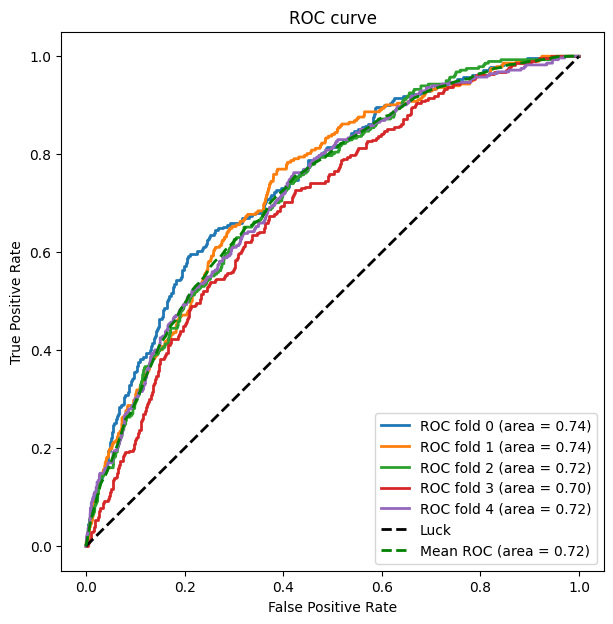

In [71]:
# K fold cross validation
K = 5
eval_size = int(np.round(1./K))
skf = StratifiedKFold(n_splits=K)


fig = plt.figure(figsize=(7,7))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
lw = 2
i = 0
roc_aucs_xgbopt = []
for train_indices, test_indices in skf.split(x_df, y_df['Label']):
    X_train, y_train = x_df.iloc[train_indices], y_df['Label'].iloc[train_indices]
    X_valid, y_valid = x_df.iloc[test_indices], y_df['Label'].iloc[test_indices]
    class_weight_scale = 1.*y_train.value_counts()[0]/y_train.value_counts()[1]
    print('class weight scale : {}'.format(class_weight_scale))
    xgb_opt.set_params(**{'scale_pos_weight' : class_weight_scale})
    xgb_opt.fit(X_train,y_train)
    xgb_opt_pred_prob = xgb_opt.predict_proba(X_valid)
    fpr, tpr, thresholds = roc_curve(y_valid, xgb_opt_pred_prob[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    roc_aucs_xgbopt.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= K
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

fig.savefig('/content/ROC.png')

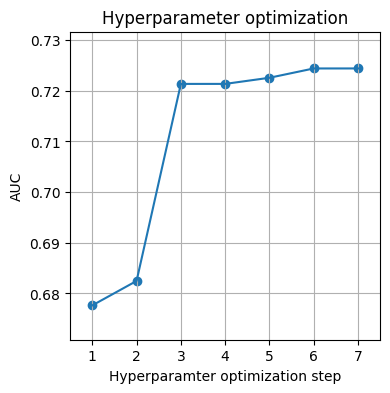

In [72]:
if optimize:

    aucs = [np.mean(roc_aucs_xgb1),
            gsearch0.best_score_,
            gsearch1.best_score_,
            gsearch2.best_score_,
            gsearch3.best_score_,
            gsearch4.best_score_,
            np.mean(roc_aucs_xgbopt)]

    fig = plt.figure(figsize=(4,4))
    plt.scatter(np.arange(1,len(aucs)+1), aucs)
    plt.plot(np.arange(1,len(aucs)+1), aucs)
    plt.xlim([0.5, len(aucs)+0.5])
    plt.ylim([0.99*aucs[0], 1.01*aucs[-1]])
    plt.xlabel('Hyperparamter optimization step')
    plt.ylabel('AUC')
    plt.title('Hyperparameter optimization')
    plt.grid()
    fig.savefig('/content/optimization.png')

In [73]:
print(classification_report(y_true = y_df.Label, y_pred = np.zeros(y_df.shape[0])))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     10658
           1       0.00      0.00      0.00      1409

    accuracy                           0.88     12067
   macro avg       0.44      0.50      0.47     12067
weighted avg       0.78      0.88      0.83     12067



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
print(classification_report(y_true = y_df.Label, y_pred = xgb_opt.predict(x_df)))

              precision    recall  f1-score   support

           0       0.95      0.69      0.80     10658
           1       0.24      0.73      0.36      1409

    accuracy                           0.70     12067
   macro avg       0.59      0.71      0.58     12067
weighted avg       0.87      0.70      0.75     12067



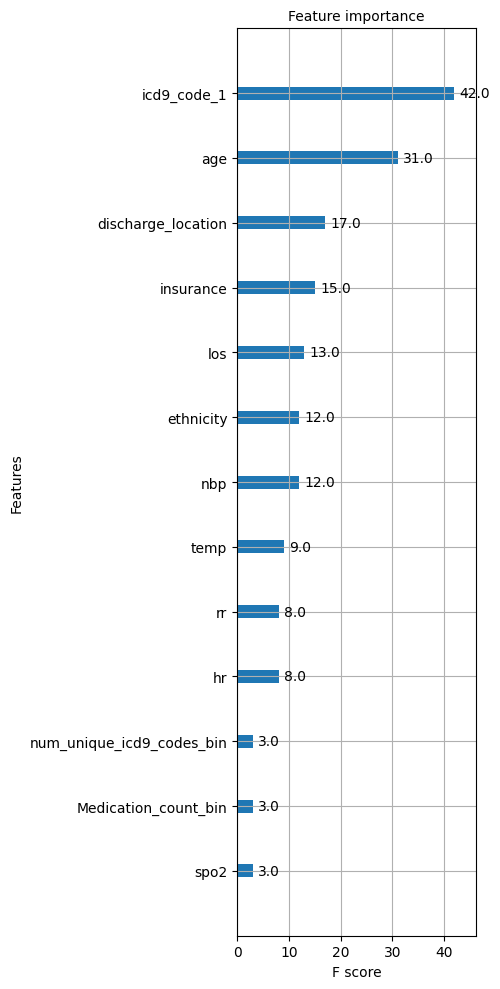

In [75]:
def my_plot_importance(booster, figsize, **kwargs):
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=(figsize))
    plot_importance(booster=booster, ax=ax, **kwargs)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label,] +
ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)
    plt.tight_layout()
    fig.savefig('/content/Feature_importance.png')

my_plot_importance(xgb_opt, (5,10))